# 03a10c At Only -- Top Neg Correlations features

In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import pickle 
import time 

from scipy import stats

from xgboost import XGBClassifier

from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
# from sklearn.inspection import permutation_importance

import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="white")

from collections import Counter

import sys; sys.path.insert(0, '..') # add parent folder path where lib folder is
from atbotml.custom_fuctions import *

## Notebook parameters

In [2]:
nb_id = f'03a10c'
# nb_long_id = f'{nb_id}_TopCorr_PosNeg' # Pos, Neg, PosNeg
num_classes = 10
random_state = 42

## Load data

In [3]:
# load complete training dataframe
df = pd.read_pickle("./01_AtBot_data.pkl")
print(f"Number of data samples: {len(df)}")
print(f"Number of features: {len(df.columns)-6}")

# extract feature names from RNASeq data
gene_names = list(df)[6:29107]

# Arabidopsis only feature gene set
n_At = 20340
At_list = gene_names[0:n_At]
print(f"Number of At genes: {n_At}")
df

Number of data samples: 1092
Number of features: 29101
Number of At genes: 20340


,Index,LibraryID,HostGenoType,Sample,Isolate,Lesion,AT1G01010,AT1G01040,AT1G01046,AT1G01050,...,BCIN18G00020,BCIN18G00060,BCIN18G00145,BCIN18G00180,BCIN18G00190,EFBCT00000013145,EFBCT00000013262,EFBCT00000013292,ENSRNA049512921.T1,ENSRNA049513883.T1
0,coi1_1,coi.1.G1E.1,coi1,1,1.01.01,36.590004,39.556340,0.000000,0.000000,21.373592,...,0.0,0.000000,0.000000,0.000000,0.000000,12.438875,0.000000,0.000000,0.000000,5.321551
1,coi1_1,coi.1.G1F.1,coi1,1,1.01.01,36.590004,16.918722,0.000000,0.000000,119.029216,...,0.0,0.000000,0.000000,0.000000,0.000000,15.521645,0.000000,0.000000,0.000000,0.000000
2,coi1_1,coi.1.G2F.1,coi1,1,1.01.01,36.590004,14.735361,0.000000,0.000000,58.388002,...,0.0,0.000000,0.000000,0.000000,0.000000,76.250891,0.000000,0.000000,0.000000,0.000000
3,coi1_1,coi.1.G2E.1,coi1,1,1.01.01,36.590004,10.552052,0.000000,1.000161,19.548414,...,0.0,0.000000,0.000000,0.000000,0.000000,41.388120,73.847835,53.937879,0.000000,5.059001
4,coi1_10,coi.1.G2E.10,coi1,10,1.02.04,36.418731,15.229003,0.000000,0.000000,99.136624,...,0.0,15.577566,32.042486,0.000000,24.233666,47.555802,0.000000,54.228767,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1087,npr1_97,npr.1.G1F.972,npr1,97,1.05.16,20.747628,4.210585,0.226497,0.000000,88.664582,...,0.0,4.623277,12.227030,3.334425,16.953341,12.097817,0.000000,13.795366,0.000000,0.000000
1088,npr1_97,npr.1.G2E.971,npr1,97,1.05.16,20.747628,3.895372,0.000000,0.000000,18.900222,...,0.0,5.101576,16.951453,7.924833,14.651827,48.519908,11.222415,24.590291,1.537600,0.000000
1089,npr1_97,npr.1.G2E.972,npr1,97,1.05.16,20.747628,7.494782,0.000000,0.000000,14.318503,...,0.0,7.547289,19.236880,3.313311,15.314539,42.074248,18.768019,27.416028,0.642859,3.857151
1090,npr1_97,npr.1.G2F.971,npr1,97,1.05.16,20.747628,1.965208,0.000000,0.000000,23.361068,...,0.0,1.803102,16.690115,4.551550,37.868097,132.109896,103.127734,0.000000,0.000000,0.000000


### Features list

In [4]:
# df_At_pos_corr = pd.read_csv("../data/raw/top_correlation/AtTop1000PositiveCorLesion.csv")
# At_pos_corr_features = df_At_pos_corr['GeneID'].to_list()

df_At_neg_corr = pd.read_csv("../data/raw/top_correlation/AtTop1000NegativeCorLesion.csv")
At_neg_corr_features = df_At_neg_corr['GeneID'].to_list()

In [5]:
# features = At_pos_corr_features
# feature_title = "Positive Correlations"
# nb_long_id = f'{nb_id}_TopCorr_Pos' # Pos, Neg, PosNeg

features = At_neg_corr_features
feature_title = "Negative Correlations"
nb_long_id = f'{nb_id}_TopCorr_Neg' # Pos, Neg, PosNeg

# features = set(At_pos_corr_features) | set(At_neg_corr_features)
# feature_title = "Positive/Negative Correlations"
# nb_long_id = f'{nb_id}_TopCorr_PosNeg' # Pos, Neg, PosNeg


print(f'Number of features: {len(features)}')
print(f'Unique features: {len(set(features))}')

ugene_names = [each_string.upper() for each_string in gene_names]
common_features = set(features) & set(ugene_names)

features_list = common_features
topN = len(features_list)

print(f'Intersection: {len(common_features)}')

Number of features: 1000
Unique features: 1000
Intersection: 762


In [6]:
# save features
df_fs = pd.DataFrame(features_list) 
df_fs.to_csv(f"../results/03_At/features/{nb_long_id}_list_{topN}.csv", header=False, index=False)

### Training, validation, and test data

In [6]:
# load training, validation data
f = open("01_train_test_data.pkl", 'rb')
train_test_data = pickle.load(f)
f.close()

df_X_train = train_test_data['df_X_train']
df_X_train = df_X_train.loc[:,features_list]

df_X_test = train_test_data['df_X_test']
df_X_test = df_X_test.loc[:,features_list]

y_train = train_test_data['y_train']
y_test = train_test_data['y_test']
scaler = train_test_data['scaler']

print(f"Training and validation sets")
print(f"X_train: {np.shape(df_X_train)}")
print(f"X_test: {np.shape(df_X_test)}")
print(f"y_train: {np.shape(y_train)}")
print(f"y_test: {np.shape(y_test)}")

# At Only test data
f = open("01_At_test_data.pkl", 'rb')
df_At_X_test_scaled = pickle.load(f)
f.close()

df_At_X_test_scaled = df_At_X_test_scaled.loc[:,features_list]

print(f"\nTest set")
print(f"At_X_test_scaled: {np.shape(df_At_X_test_scaled)}")

# At-Psy test data
f = open("01_AtPsy_test_data.pkl", 'rb')
df_AtPsy_X_test_scaled = pickle.load(f)
f.close()

df_AtPsy_X_test_scaled = df_AtPsy_X_test_scaled.loc[:,features_list]

print(f"\nAtPsy Test set")
print(f"At_X_test_scaled: {np.shape(df_AtPsy_X_test_scaled)}")

X_train = df_X_train.to_numpy()
X_test = df_X_test.to_numpy()
At_X_test_scaled = df_At_X_test_scaled.to_numpy()
AtPsy_X_test_scaled = df_AtPsy_X_test_scaled.to_numpy()

Training and validation sets
X_train: (2060, 762)
X_test: (328, 762)
y_train: (2060,)
y_test: (328,)

Test set
At_X_test_scaled: (6, 762)

AtPsy Test set
At_X_test_scaled: (100, 762)


In [7]:
X_train = df_X_train.to_numpy()
X_test = df_X_test.to_numpy()
At_X_test_scaled = df_At_X_test_scaled.to_numpy()

## DNN

Classification accuracy is almost universally inappropriate for imbalanced classification.

For imbalanced classification problems, the *majority class* is typically referred to as the negative outcome (e.g. such as “no change” or “negative test result“), and the *minority class* is typically referred to as the positive outcome (e.g. “change” or “positive test result“).

**Sensitivity-Specificity Metrics** <br>
Sensitivity = TruePositive / (TruePositive + FalseNegative) *<br>
Specificity = TrueNegative / (FalsePositive + TrueNegative) <br>
G-Mean = sqrt(Sensitivity * Specificity)<br>




**Precision-Recall Metrics**<br>
Precision = TruePositive / (TruePositive + FalsePositive)<br>
Recall = TruePositive / (TruePositive + FalseNegative)<br>
F-Measure = (2 * Precision * Recall) / (Precision + Recall) *

### Train

In [8]:
model, history = train_dnn_1layer(X_train, y_train, X_test, y_test, num_classes, epochs=50)

2021-09-21 18:48:42.938002: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-09-21 18:48:42.938165: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-09-21 18:48:42.975114: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)


Epoch 1/50
65/65 [==============================] - 1s 11ms/step - loss: 2.1456 - sparse_categorical_accuracy: 0.3616 - val_loss: 2.4577 - val_sparse_categorical_accuracy: 0.2134
Epoch 2/50
65/65 [==============================] - 0s 2ms/step - loss: 0.9198 - sparse_categorical_accuracy: 0.6979 - val_loss: 2.5934 - val_sparse_categorical_accuracy: 0.2378
Epoch 3/50
65/65 [==============================] - 0s 2ms/step - loss: 0.5875 - sparse_categorical_accuracy: 0.7965 - val_loss: 2.7774 - val_sparse_categorical_accuracy: 0.2165
Epoch 4/50
65/65 [==============================] - 0s 2ms/step - loss: 0.5053 - sparse_categorical_accuracy: 0.8358 - val_loss: 3.0456 - val_sparse_categorical_accuracy: 0.2378
Epoch 5/50
65/65 [==============================] - 0s 2ms/step - loss: 0.4504 - sparse_categorical_accuracy: 0.8658 - val_loss: 3.0990 - val_sparse_categorical_accuracy: 0.2622
Epoch 6/50
65/65 [==============================] - 0s 2ms/step - loss: 0.2978 - sparse_categorical_accuracy:

### Test1

/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy:	 23.78%
Precision:	 16.32%
Recall:		 16.78%
F1 score:	 16.21%


2021-09-21 18:48:54.943168: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: ./models/03a10c_TopCorr_Neg_dnn_model_f762/assets
Written to: ./models/03a10c_TopCorr_Neg_dnn_results_f762.pkl


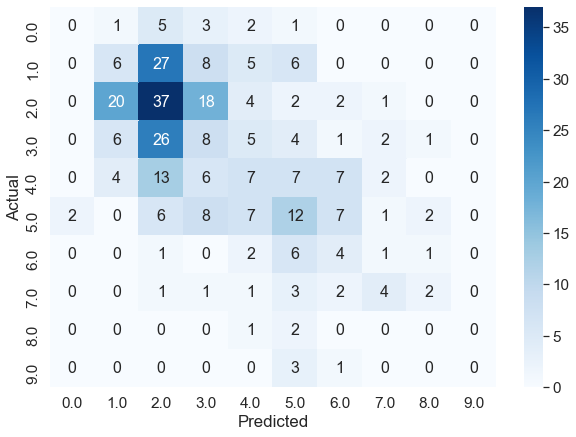

In [9]:
# Evaluate performance on Test set1
predictions = model.predict(X_test)
dnn_y_pred = np.argmax(predictions, 1)
dnn_score = get_sk_metrics(y_test, dnn_y_pred)
dnn_cm = plot_confusion_matrix(y_test, dnn_y_pred)

# save the keras model and results
filename = f"./models/{nb_long_id}_dnn_model_f{topN}"
model.save(filename)

filename = f"./models/{nb_long_id}_dnn_results_f{topN}.pkl"
pickle.dump([history.history, dnn_score, dnn_cm], open(filename, 'wb'))
print(f"Written to: {filename}")

### Test2

In [10]:
# Evaluate performance on Test set2
predictions = model.predict(At_X_test_scaled)
dnn_y_pred = np.argmax(predictions, 1)

filename = f"../results/03_At/prediction/{nb_long_id}_dnn_test_predict_f{topN}.pkl"
pickle.dump(dnn_y_pred, open(filename, 'wb'))
print(f"Written to: {filename}")

dnn_y_pred

Written to: ../results/03_At/prediction/03a10c_TopCorr_Neg_dnn_test_predict_f762.pkl


array([2, 2, 2, 5, 5, 5])

### Test3 AtPsy

In [11]:
# # load model and results
# filename = f'./models/{nb_long_id}_dnn_model_f{topN}'
# print(filename)
# model = keras.models.load_model(filename)

# filename = f'./models/{nb_long_id}_dnn_results_f{topN}.pkl'
# # history, dnn_score, dnn_cm = pickle.load(open(filename,'rb'))

# predictions = model.predict(X_test)
# dnn_y_pred = np.argmax(predictions, 1)
# dnn_score = get_sk_metrics(y_test, dnn_y_pred)
# dnn_cm = plot_confusion_matrix(y_test, dnn_y_pred)

In [12]:
X_test_scaled = AtPsy_X_test_scaled

predictions = model.predict(X_test_scaled)
dnn_y_pred = np.argmax(predictions, 1)

filename = f"../results/03_At/prediction/{nb_long_id}_dnn_test_AtPsy_predict_f{topN}.pkl"
pickle.dump(dnn_y_pred, open(filename, 'wb'))
print(f"Written to: {filename}")

dnn_y_pred

Written to: ../results/03_At/prediction/03a10c_TopCorr_Neg_dnn_test_AtPsy_predict_f762.pkl


array([5, 5, 2, 2, 5, 5, 5, 2, 5, 1, 5, 5, 5, 5, 5, 6, 5, 5, 6, 1, 5, 5,
       5, 3, 5, 5, 2, 3, 5, 5, 5, 2, 5, 5, 5, 5, 5, 2, 3, 5, 5, 5, 3, 3,
       5, 5, 5, 5, 3, 3, 3, 3, 5, 3, 3, 5, 5, 5, 1, 5, 5, 5, 5, 5, 5, 5,
       5, 2, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 3, 5, 5, 2, 5, 5, 5, 3, 3,
       1, 5, 3, 3, 2, 3, 5, 5, 5, 5, 5, 5])

## XGBoost
XGBoost is an implementation of gradient boosted decision trees designed for speed and performance.

### Train

In [13]:
xgb = XGBClassifier()

t0 = time.time()
xgb.fit(X_train, y_train)
t = time.time() - t0

print(f"\nelapsed time: {(t/60):.2f} mins")
print()

/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:49:03] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.

elapsed time: 0.17 mins



### Test1

Accuracy:	 24.70%
Precision:	 26.65%
Recall:		 21.69%
F1 score:	 21.91%
Written to: ./models/03a10c_TopCorr_Neg_xgb_model_results_f762.pkl


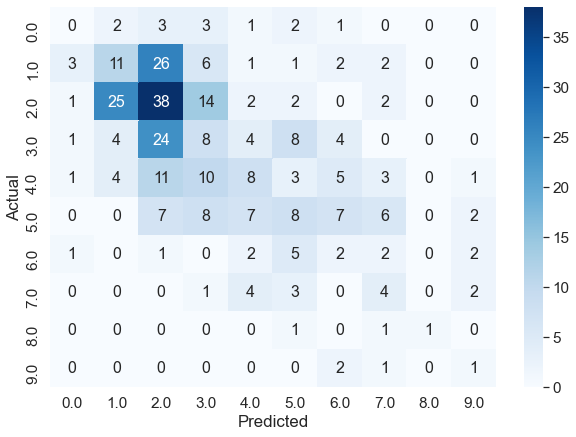

In [14]:
xgb_y_pred = xgb.predict(X_test)
xgb_score = get_sk_metrics(y_test, xgb_y_pred, average='macro')
xgb_cm = plot_confusion_matrix(y_test, xgb_y_pred)

filename = f"./models/{nb_long_id}_xgb_model_results_f{topN}.pkl"
pickle.dump([xgb, xgb_score, xgb_cm], open(filename, 'wb'))
print(f"Written to: {filename}")

### Test2

In [15]:
xgb_y_pred = xgb.predict(At_X_test_scaled)

filename = f"../results/03_At/prediction/{nb_long_id}_xgb_test_predict_f{topN}.pkl"
pickle.dump(xgb_y_pred, open(filename, 'wb'))
print(f"Written to: {filename}")
xgb_y_pred

Written to: ../results/03_At/prediction/03a10c_TopCorr_Neg_xgb_test_predict_f762.pkl


array([0., 3., 0., 5., 2., 2.])

### Test3 AtPsy

In [16]:
# filename = f'./models/{nb_long_id}_xgb_model_results_f{topN}.pkl'
# print(filename)
# xgb, xgb_score, xgb_cm = pickle.load(open(filename,'rb'))

# xgb_y_pred = xgb.predict(X_test)
# xgb_score = get_sk_metrics(y_test, xgb_y_pred, average='macro')
# xgb_cm = plot_confusion_matrix(y_test, xgb_y_pred)

In [17]:
X_test_scaled = AtPsy_X_test_scaled

xgb_y_pred = xgb.predict(X_test_scaled)

filename = f"../results/03_At/prediction/{nb_long_id}_xgb_test_AtPsy_predict_f{topN}.pkl"
pickle.dump(xgb_y_pred, open(filename, 'wb'))
print(f"Written to: {filename}")
xgb_y_pred

Written to: ../results/03_At/prediction/03a10c_TopCorr_Neg_xgb_test_AtPsy_predict_f762.pkl


array([2., 2., 7., 2., 2., 2., 2., 2., 7., 4., 2., 2., 5., 5., 7., 5., 2.,
       2., 2., 2., 2., 2., 2., 5., 5., 2., 7., 2., 7., 2., 2., 2., 2., 5.,
       2., 5., 2., 2., 2., 2., 2., 2., 2., 2., 5., 2., 7., 2., 2., 2., 2.,
       2., 7., 2., 2., 2., 2., 2., 7., 2., 2., 2., 2., 2., 5., 5., 2., 2.,
       7., 7., 5., 7., 7., 2., 2., 7., 7., 7., 7., 2., 7., 7., 7., 2., 7.,
       5., 2., 2., 2., 7., 2., 2., 2., 2., 2., 2., 2., 2., 5., 2.])

## Random Forest

### Train

In [18]:
rf = RandomForestClassifier(n_estimators=100, max_depth=30, random_state=0)

t0 = time.time()
rf.fit(X_train, y_train)
t = time.time() - t0

print(f"\nelapsed time: {(t/60):.2f} mins")
print()


elapsed time: 0.03 mins



### Test1

Accuracy:	 28.05%
Precision:	 17.76%
Recall:		 18.26%
F1 score:	 17.63%
Written to: ./models/03a10c_TopCorr_Neg_rf_model_results_f762.pkl


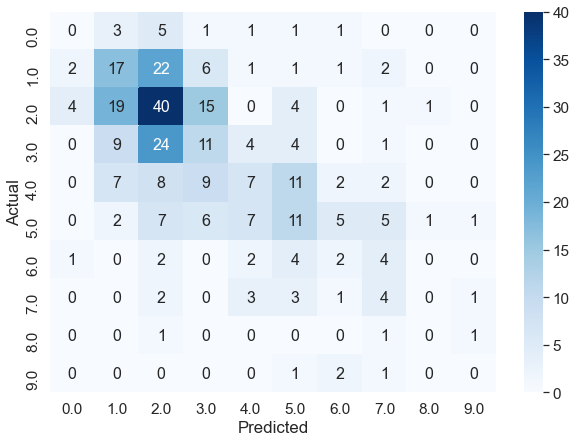

In [19]:
rf_y_pred = rf.predict(X_test)
rf_score = get_sk_metrics(y_test, rf_y_pred, average='macro')
rf_cm = plot_confusion_matrix(y_test, rf_y_pred)

filename = f"./models/{nb_long_id}_rf_model_results_f{topN}.pkl"
pickle.dump([rf, rf_score, rf_cm], open(filename, 'wb'))
print(f"Written to: {filename}")

### Test2

In [20]:
rf_y_pred = rf.predict(At_X_test_scaled)

filename = f"../results/03_At/prediction/{nb_long_id}_rf_test_predict_f{topN}.pkl"
pickle.dump(rf_y_pred, open(filename, 'wb'))
print(f"Written to: {filename}")
rf_y_pred

Written to: ../results/03_At/prediction/03a10c_TopCorr_Neg_rf_test_predict_f762.pkl


array([1., 5., 1., 5., 5., 5.])

### Test3 AtPsy

In [21]:
# filename = f'./models/{nb_long_id}_rf_model_results_f{topN}.pkl'
# print(filename)
# rf, rf_score, rf_cm = pickle.load(open(filename,'rb'))

# rf_y_pred = rf.predict(X_test)
# rf_score = get_sk_metrics(y_test, rf_y_pred, average='macro')
# rf_cm = plot_confusion_matrix(y_test, rf_y_pred)

In [22]:
X_test_scaled = AtPsy_X_test_scaled
rf_y_pred = rf.predict(X_test_scaled)

filename = f"../results/03_At/prediction/{nb_long_id}_rf_test_AtPsy_predict_f{topN}.pkl"
pickle.dump(rf_y_pred, open(filename, 'wb'))
print(f"Written to: {filename}")
rf_y_pred

Written to: ../results/03_At/prediction/03a10c_TopCorr_Neg_rf_test_AtPsy_predict_f762.pkl


array([5., 5., 5., 5., 5., 5., 5., 5., 7., 5., 3., 3., 5., 5., 5., 8., 3.,
       3., 5., 5., 5., 5., 5., 5., 3., 5., 5., 5., 5., 5., 5., 5., 2., 5.,
       3., 7., 5., 2., 2., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5.,
       5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 3., 5., 5., 5., 5.,
       5., 5., 5., 2., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 2., 5., 5.,
       5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5.])

## SVM
### RBF kernel
#### Train

In [23]:
#Create a svm Classifier
svm = SVC() 

t0 = time.time()
svm.fit(X_train, y_train)
t = time.time() - t0

print(f"\nelapsed time: {(t/60):.2f} mins")
print()


elapsed time: 0.01 mins



#### Test1

/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy:	 27.44%
Precision:	 17.83%
Recall:		 17.27%
F1 score:	 17.13%
Written to: ./models/03a10c_TopCorr_Neg_svm_model_results_f762.pkl


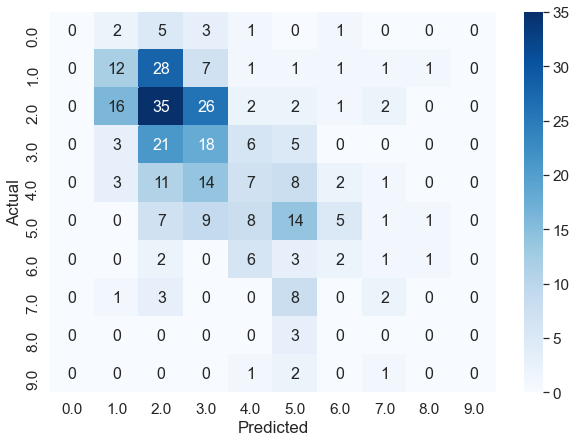

In [24]:
#Predict the response for test dataset
svm_y_pred = svm.predict(X_test)
svm_score = get_sk_metrics(y_test, svm_y_pred, average='macro')
svm_cm = plot_confusion_matrix(y_test, svm_y_pred)

filename = f"./models/{nb_long_id}_svm_model_results_f{topN}.pkl"
pickle.dump([svm, svm_score, svm_cm], open(filename, 'wb'))
print(f"Written to: {filename}")

#### Test2

In [25]:
#Predict the response for test dataset
svm_y_pred = svm.predict(At_X_test_scaled)

filename = f"../results/03_At/prediction/{nb_long_id}_svm_test_predict_f{topN}.pkl"
pickle.dump(svm_y_pred, open(filename, 'wb'))
print(f"Written to: {filename}")
svm_y_pred

Written to: ../results/03_At/prediction/03a10c_TopCorr_Neg_svm_test_predict_f762.pkl


array([2., 2., 2., 5., 5., 5.])

#### Test3 AtPsy

In [26]:
# filename = f'./models/{nb_long_id}_svm_model_results_f{topN}.pkl'
# print(filename)
# svm, svm_score, svm_cm = pickle.load(open(filename,'rb'))

# svm_y_pred = svm.predict(X_test)
# svm_score = get_sk_metrics(y_test, svm_y_pred, average='macro')
# svm_cm = plot_confusion_matrix(y_test, svm_y_pred)

In [27]:
X_test_scaled = AtPsy_X_test_scaled
svm_y_pred = svm.predict(X_test_scaled)

filename = f"../results/03_At/prediction/{nb_long_id}_svm_test_AtPsy_predict_f{topN}.pkl"
pickle.dump(svm_y_pred, open(filename, 'wb'))
print(f"Written to: {filename}")
svm_y_pred

Written to: ../results/03_At/prediction/03a10c_TopCorr_Neg_svm_test_AtPsy_predict_f762.pkl


array([2., 2., 2., 2., 5., 5., 5., 2., 5., 2., 2., 2., 5., 5., 5., 2., 2.,
       2., 2., 2., 5., 2., 5., 2., 2., 2., 2., 2., 5., 5., 5., 2., 2., 5.,
       2., 5., 2., 2., 2., 5., 2., 5., 2., 2., 2., 5., 2., 5., 2., 2., 2.,
       2., 5., 2., 2., 5., 5., 2., 2., 5., 2., 5., 2., 2., 5., 5., 5., 2.,
       5., 5., 2., 2., 5., 5., 2., 2., 5., 5., 5., 2., 5., 5., 2., 5., 2.,
       5., 2., 2., 2., 5., 2., 2., 2., 2., 5., 5., 2., 2., 5., 5.])

### Linear kernel
#### Train

In [28]:
#Create a svm Classifier
svm_lin = SVC(kernel='linear') # Linear Kernel

t0 = time.time()
#Train the model using the training sets
svm_lin.fit(X_train, y_train)
t = time.time() - t0

print(f"\nelapsed time: {(t/60):.2f} mins")
print()


elapsed time: 0.01 mins



#### Test1

Accuracy:	 26.83%
Precision:	 16.91%
Recall:		 17.29%
F1 score:	 16.89%
Written to: ./models/03a10c_TopCorr_Neg_svm_lin_model_results_f762.pkl


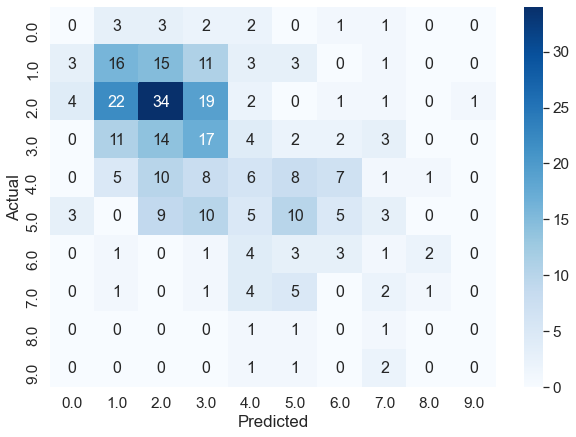

In [29]:
svm_lin_y_pred = svm_lin.predict(X_test)
svm_lin_score = get_sk_metrics(y_test, svm_lin_y_pred, average='macro')
svm_lin_cm = plot_confusion_matrix(y_test, svm_lin_y_pred)

filename = f"./models/{nb_long_id}_svm_lin_model_results_f{topN}.pkl"
pickle.dump([svm_lin, svm_lin_score, svm_lin_cm], open(filename, 'wb'))
print(f"Written to: {filename}")

#### Test2

In [30]:
svm_lin_y_pred = svm_lin.predict(At_X_test_scaled)

filename = f"../results/03_At/prediction/{nb_long_id}_svm_lin_test_predict_f{topN}.pkl"
pickle.dump(svm_lin_y_pred, open(filename, 'wb'))
print(f"Written to: {filename}")
svm_lin_y_pred

Written to: ../results/03_At/prediction/03a10c_TopCorr_Neg_svm_lin_test_predict_f762.pkl


array([0., 1., 1., 5., 5., 5.])

#### Test3 AtPsy

In [31]:
# filename = f'./models/{nb_long_id}_svm_lin_model_results_f{topN}.pkl'
# print(filename)
# svm_lin, svm_lin_score, svm_lin_cm = pickle.load(open(filename,'rb'))

# svm_lin_y_pred = svm_lin.predict(X_test)
# svm_lin_score = get_sk_metrics(y_test, svm_lin_y_pred, average='macro')
# svm_lin_cm = plot_confusion_matrix(y_test, svm_lin_y_pred)

In [32]:
X_test_scaled = AtPsy_X_test_scaled

svm_lin_y_pred = svm_lin.predict(X_test_scaled)

filename = f"../results/03_At/prediction/{nb_long_id}_svm_lin_test_AtPsy_predict_f{topN}.pkl"
pickle.dump(svm_lin_y_pred, open(filename, 'wb'))
print(f"Written to: {filename}")
svm_lin_y_pred

Written to: ../results/03_At/prediction/03a10c_TopCorr_Neg_svm_lin_test_AtPsy_predict_f762.pkl


array([5., 5., 5., 5., 5., 5., 5., 5., 5., 8., 8., 5., 5., 5., 5., 8., 5.,
       8., 5., 8., 5., 5., 5., 3., 5., 5., 5., 5., 5., 3., 5., 5., 4., 5.,
       5., 5., 5., 5., 5., 5., 5., 3., 5., 5., 5., 5., 5., 3., 5., 3., 5.,
       5., 5., 5., 5., 5., 5., 5., 5., 8., 5., 5., 5., 5., 5., 5., 5., 2.,
       5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 8., 7., 5., 3., 5., 5., 3.,
       3., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5.])

## Plots
### Performance metrics

**Precision** is a measure of the ability of a classification model to identify only the relevant data points.<br>
**Recall** is a measure of the ability of a model to find all the relevant cases within a dataset.

Saving to ./figures/03a10c_TopCorr_Neg_score_f762.pdf



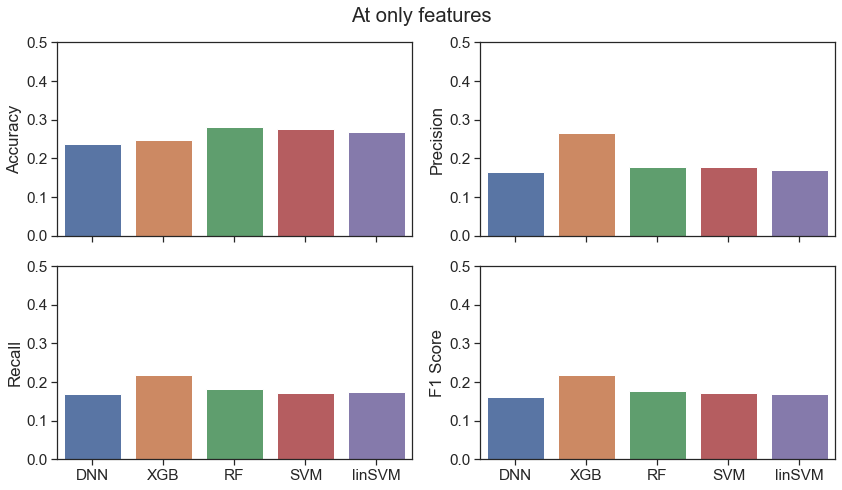

,Accuracy,Precision,Recall,F1 Score
DNN,0.237805,0.163203,0.167803,0.162108
XGB,0.246951,0.266530,0.216893,0.219054
RF,0.280488,0.177611,0.182633,0.176251
SVM,0.274390,0.178258,0.172653,0.171297
linSVM,0.268293,0.169099,0.172872,0.168940


In [33]:
max_ylim = 0.5
file_out = f'./figures/{nb_long_id}_score_f{topN}.pdf'
fig_title = 'At only features'
df_metrics = plot_performance_metrics(nb_long_id, max_ylim, file_out, fig_title, feature_size=topN)
df_metrics

#### Fuzzy results

../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])


Saving to ./figures/03a10c_TopCorr_Neg_fuzzy_score_f762.pdf



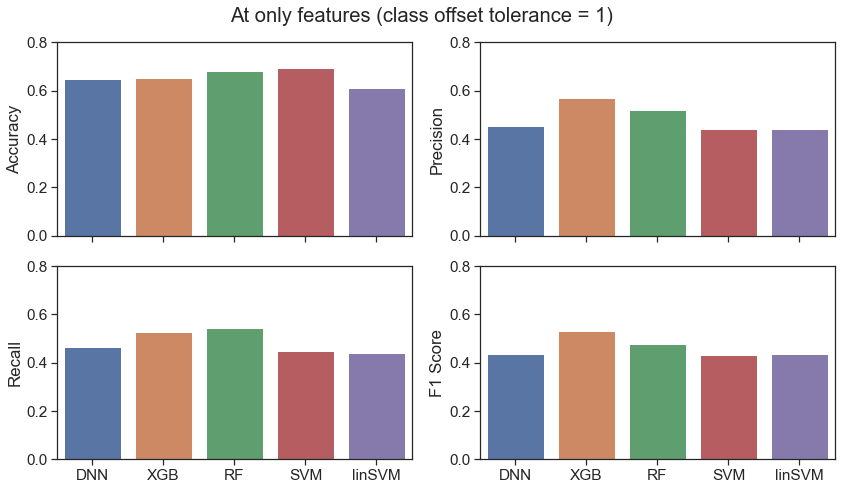

,Accuracy,Precision,Recall,F1 Score
DNN,0.649390,0.455282,0.466398,0.435795
XGB,0.652439,0.568432,0.527960,0.532306
RF,0.682927,0.517720,0.544381,0.478021
SVM,0.695122,0.443045,0.447491,0.430076
linSVM,0.609756,0.439994,0.439407,0.436128


In [34]:
max_ylim = 0.8
offset = 1
file_out = f'./figures/{nb_long_id}_fuzzy_score_f{topN}.pdf'
fig_title = f'At only features (class offset tolerance = {offset})'
df_metrics = plot_performance_metrics(nb_long_id, max_ylim, file_out, fig_title, offset, feature_size=topN)
df_metrics

### MSE

Saving to ./figures/03a10c_TopCorr_Neg_mse_f762.pdf



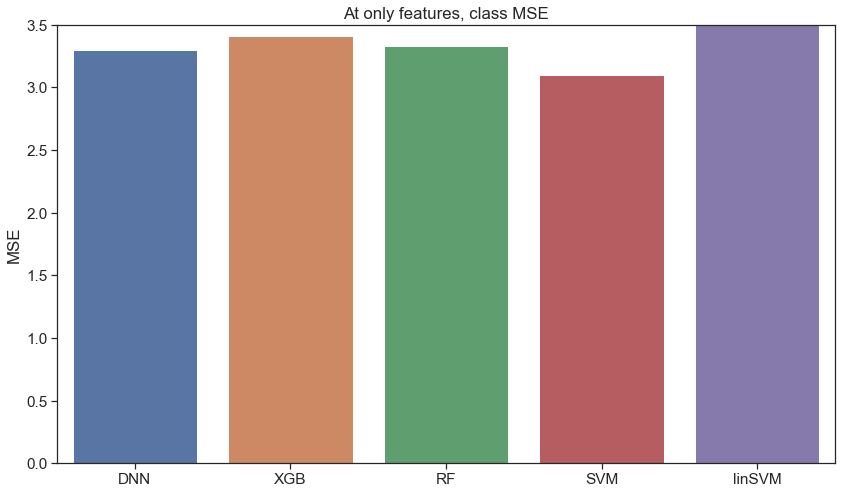

,MSE
DNN,3.298780
XGB,3.408537
RF,3.332317
SVM,3.094512
linSVM,3.756098


In [35]:
total_class_mse, class_mse, class_rss = class_error(dnn_cm)
total_class_mse

max_ylim = 3.5
file_out = f'./figures/{nb_long_id}_mse_f{topN}.pdf'
fig_title = f'At only features, class MSE'
df_metrics = plot_mse(nb_long_id, max_ylim, file_out, fig_title, feature_size=topN)
df_metrics

### Test2 prediction summary

In [36]:
cols = ['DNN', 'XGB', 'RF', 'SVM', 'linSVM']
ml_predictions = np.vstack((dnn_y_pred, xgb_y_pred, rf_y_pred, svm_y_pred, svm_lin_y_pred)).T
df_test2_predict = pd.DataFrame(data=ml_predictions, columns=cols, )

print(f"{nb_long_id} Test Predictions")
filename = f"../results/03_At/prediction/{nb_long_id}_test_predictions_f{topN}.pkl"
pickle.dump(df_test2_predict, open(filename, 'wb'))
print(f"Written to: {filename}")

df_test2_predict

03a10c_TopCorr_Neg Test Predictions
Written to: ../results/03_At/prediction/03a10c_TopCorr_Neg_test_predictions_f762.pkl


,DNN,XGB,RF,SVM,linSVM
0,5.0,2.0,5.0,2.0,5.0
1,5.0,2.0,5.0,2.0,5.0
2,2.0,7.0,5.0,2.0,5.0
3,2.0,2.0,5.0,2.0,5.0
4,5.0,2.0,5.0,5.0,5.0
...,...,...,...,...,...
95,5.0,2.0,5.0,5.0,5.0
96,5.0,2.0,5.0,2.0,5.0
97,5.0,2.0,5.0,2.0,5.0
98,5.0,5.0,5.0,5.0,5.0


### Test3 prediction summary

In [37]:
cols = ['DNN', 'XGB', 'RF', 'SVM', 'linSVM']
ml_predictions = np.vstack((dnn_y_pred, xgb_y_pred, rf_y_pred, svm_y_pred, svm_lin_y_pred)).T
df_test3_predict = pd.DataFrame(data=ml_predictions, columns=cols, )

print(f"{nb_long_id} Test Predictions")
filename = f"../results/03_At/prediction/{nb_long_id}_test_AtPsy_predictions_f{topN}.pkl"
pickle.dump(df_test3_predict, open(filename, 'wb'))
print(f"Written to: {filename}")

df_test3_predict

03a10c_TopCorr_Neg Test Predictions
Written to: ../results/03_At/prediction/03a10c_TopCorr_Neg_test_AtPsy_predictions_f762.pkl


,DNN,XGB,RF,SVM,linSVM
0,5.0,2.0,5.0,2.0,5.0
1,5.0,2.0,5.0,2.0,5.0
2,2.0,7.0,5.0,2.0,5.0
3,2.0,2.0,5.0,2.0,5.0
4,5.0,2.0,5.0,5.0,5.0
...,...,...,...,...,...
95,5.0,2.0,5.0,5.0,5.0
96,5.0,2.0,5.0,2.0,5.0
97,5.0,2.0,5.0,2.0,5.0
98,5.0,5.0,5.0,5.0,5.0
